# Edit Card Impact Analysis Report

*2019 December 18*
<br />
*Megan Neisler*

[Task](https://phabricator.wikimedia.org/T221728)

## Summary ##

As part of efforts to simplifiy contributing on mobile, the Editing team worked to improve the context items (called edit cards) in the mobile visual editor. Edit cards are the part of the editing interface that shows additional details about, and actions related to, editable elements within articles. These elements include links, citations, images, infoboxes, templates, etc.

Work focused on two specific elements of edit cards: adding and modifying links and adding and modifying citations. 

[Project page](https://www.mediawiki.org/wiki/VisualEditor_on_mobile/Edit_cards)

# Hypotheses and metrics
Edit Cards and the changes to the subsequent dialogs will:

* Hypothesis 1: Make contributors more likely to start adding and modifying links and citations, since the actions to edit them will be more prominent on the page
    * Metric 1: average number of link and citation workflow starts per session

* Hypothesis 2: Make contributors more likely to finish adding and modifying links and citations, since the steps to do so will be more visible and clear.
    * Metric 2: link and citation workflow completion rate

* Hypothesis 3: Make contributors more likely to publish their edits, since it will be more clear when they have finished their task.
    * Metric 3: edit completion rate

# Instrumentation

Based on our post-deployment checks (T221254), we have detailed data on the linking and citation workflows starting 13 July 2019. For details about the linking and citation workflows, see the [data dictionary].(https://www.mediawiki.org/wiki/VisualEditor/FeatureUse_data_dictionary).

[VE Instrumentation Spec](https://docs.google.com/document/d/1n0MKZWiNm2ZviBHiImnNRnUjSp5e5JqfXorYtIsuP-0/edit)

[Instrumentation Changes](https://phabricator.wikimedia.org/T222367)

# Experiment plan

We completed a basic pre/post analysis of whether the metrics above changed due to the multiple iterative deployments of Edit Cards:

version	date deployed
* v1	21-June to Bengali, Hebrew, and Persian Wikipedias (T221314#5272510). Note: V1 was never deployed to all wikis. Since we did not start recording events until 13 July, 2019, we did not review pre and post deployments for v1 
* v2	1-August 2019 in 1.34.0-wmf.16 (T225834) to all Wikipedias.
* v3	29-August 2019 in 1.34.0-wmf.20 (T229830) to all Wikipedias.
* v4	12-September-2019 in 1.34.0-wmf.22 (T231342) to all Wikipedias.

We excluded any sessions that have a bucket set in EditAttemptStep, because those are part of the mobile-VE-as-default A/B test.


# Average number of link workflow starts per session


Notes: 
* Feature `link`
* Feature `link-internal` or `link-external` when the link flow was opened from an existing item


- When I click internal link: {feature: "link/internal", action: "context-show")
- When I click external link: feature: "link", action: "context-show". (There is no more link-external. same as just link)
- After context show, subsequent actions are just labeled as link. 


Process:
See: https://phabricator.wikimedia.org/T227933 for QA to confirm events were firing appropriately.

- Select link to edit while in edit mode. Feature: Link (if external) or Link/Internal: Action: Context-Show
- Select pencil in context window. Action: window-open-from-context
- Type in text box. Action: label-input
- Type in link search box. Action: search-pages-input
- Switch tab: panel-swtich.
- Close without saving Action: dialog-abort
- Close with saving: dialong-done (several variations of this check dictionary to confirm)


Questions:
- Do I need to find first item in sequence for external links? Seems like if I restrict to context-show that will be the key.
- Does only context_show mark start of link workflow? or start is at window-open
- Should I consider other types of links beyond internal and external links as part of this number?
- Deployed to all Wikipedias or all wikis?
- Instrumentation not deployed until July 16th? Unable to track before then. Seeing a higher rate for pre Wiki deployment levels.



## Methodology

We measured the start of a sessions with the 'window-open-from-context' action as this indicates an intent to edit in most cases. This occurs when a window was opened by clicking the edit button in a context item.

Events are recorded as follows:

Action: User clicks on an existing internal link, selects "edit"
<br />
Event: Link/internal:context-show then link:window-open-from-context

Action: User clicks an existing external link, selects "edit"
<br />
Event: Link:context-show then link:window-open-from-context

We also reviews the rate of context items show to determine if the the new design made people more likely in start editing in the first place.


In [569]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); library(lubridate); library(scales)
})

In [522]:
#Find link workflow starts measured by the window-open action.
query <-
"
--find sessions that were not included in the VE as default AB test
with non_test_sessions as (
    SELECT DISTINCT event.editing_session_id as session_id
    FROM
        event_sanitized.editattemptstep
    WHERE
        event.bucket is NULL and
        event.platform = 'phone' and
        event.editor_interface = 'visualeditor' and
--full data available on July 13
        year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) 
        )
SELECT
    to_date(dt) as date,
    event.editingsessionid as session_id,
    Count (*) as events
FROM event_sanitized.visualeditorfeatureuse as vefu
INNER JOIN
    non_test_sessions 
    ON event.editingsessionid = non_test_sessions.session_id 
WHERE

    year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) and
--Both internal and external links are labeled as link following context-open action
    event.feature = 'link' and
    event.action = 'window-open-from-context' 
GROUP BY
    to_date(dt),
    event.editingsessionid
"

In [523]:
link_workflow_starts <- wmf::query_hive(query)

In [524]:
head(link_workflow_starts, 10)

date,session_id,events
<chr>,<chr>,<int>
2019-07-13,016fff987b3829fe167e,1
2019-07-13,03d572fe5ba25895bdec,1
2019-07-13,03e596703db4e2f05f89,1
2019-07-13,03f3d5a377f150d0332c,3
2019-07-13,04afc01ca2f8f5362936,3
2019-07-13,077ea726e684473ce04a,1
2019-07-13,0ba29ce4a6114aeac65f,1
2019-07-13,0c011db6cfcf922739e3,1
2019-07-13,0cd88033ef7770fa7567,1


In [525]:
link_workflow_starts$date <- as.Date(link_workflow_starts$date, format = "%Y-%m-%d")

In [526]:
#Find the average link workflow starts per session

link_workflow_starts_avg <- link_workflow_starts %>%
    group_by(date) %>%
    summarise(total_events = sum(events),
             avg_events = mean(events))

head(link_workflow_starts_avg)

date,total_events,avg_events
<date>,<int>,<dbl>
2019-07-13,241,1.564935
2019-07-14,978,4.366071
2019-07-15,351,1.928571
2019-07-16,312,1.704918
2019-07-17,434,2.214286
2019-07-18,338,2.180645


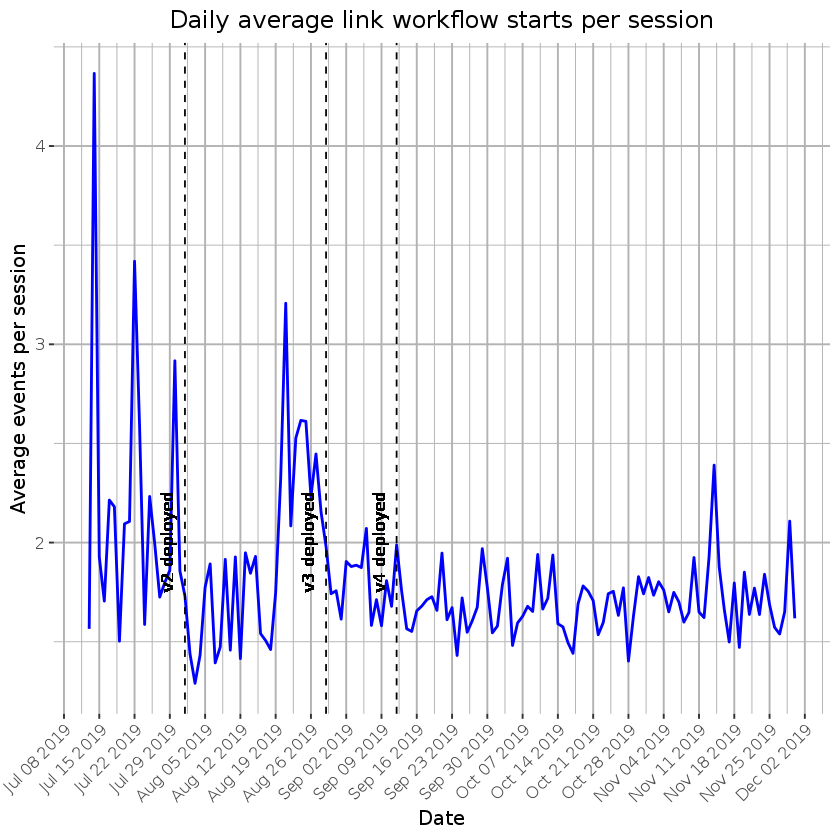

In [527]:
# Plot timeseries of average link_workflow_starts

p <- ggplot(link_workflow_starts_avg, aes(x= date, y = avg_events)) +    
  geom_line(color = 'blue', size =0.8) +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=2, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=2, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=2, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("Average events per session", labels = polloi::compress) +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "1 week") +
  labs(title = "Daily average link workflow starts per session") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom')
 
p

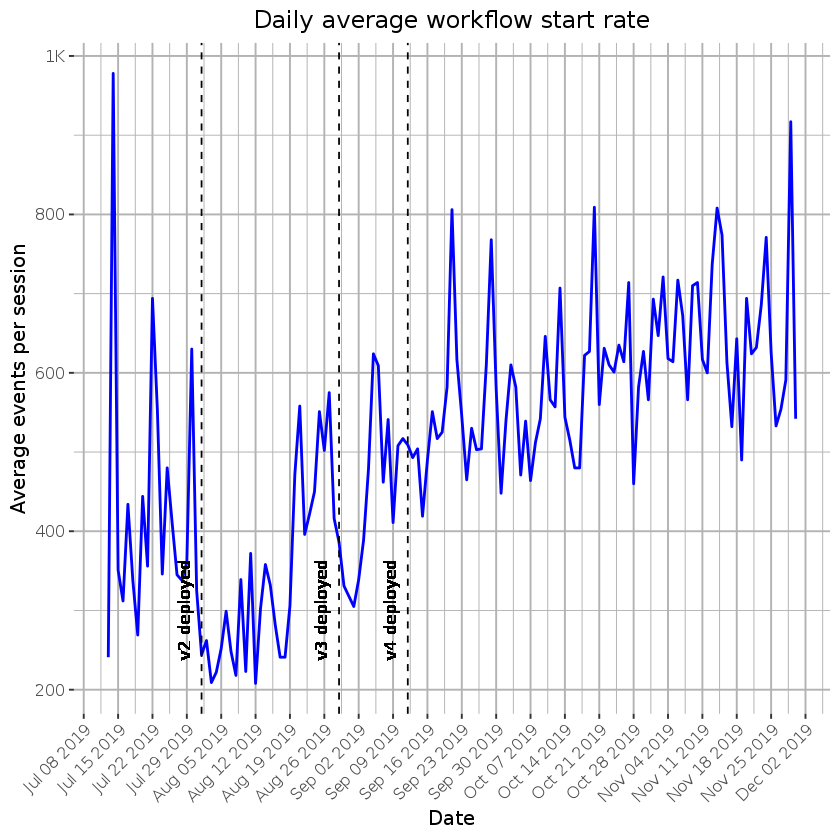

In [529]:
# Daily total link flow start rate

p <- ggplot(link_workflow_starts_avg, aes(x= date, y = total_events)) +    
  geom_line(color = 'blue', size =0.8) +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=300, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=300, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=300, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("Average events per session", labels = polloi::compress) +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "1 week") +
  labs(title = "Daily average link workflow start rate") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom')
 
p

## Review number of context items shown ##

In [530]:
#Find all context-shown items

query <-
"
--find mobile VE edit sessions that were not included in the AB test 
with non_test_sessions as (
    SELECT DISTINCT event.editing_session_id as session_id
    FROM
        event_sanitized.editattemptstep
    WHERE
        event.bucket is NULL and
        event.platform = 'phone' and
        event.editor_interface = 'visualeditor' and
        year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) 
        )
SELECT
    to_date(dt) as date,
    event.feature as feature,
    event.editingsessionid as session_id,
    Count (*) as events
FROM event_sanitized.visualeditorfeatureuse as vefu
INNER JOIN
    non_test_sessions 
    ON event.editingsessionid = non_test_sessions.session_id 
WHERE
   -- full data available as of July 13
       year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) and
    -- limiting to internal (labeled as internal) and external (labeled as link) links
    event.feature IN ('link', 'link/internal') and
    -- the first action in link workflow starts is context-show
    event.action = 'context-show' 
GROUP BY
    to_date(dt),
    event.editingsessionid,
    event.feature
"

In [539]:
head(link_context_shown_avg)

date,feature,total_events,avg_events
<chr>,<chr>,<int>,<dbl>
2019-07-13,external link,2572,14.20994
2019-07-13,internal link,31180,17.45801
2019-07-14,external link,4635,19.39331
2019-07-14,internal link,31931,16.04573
2019-07-15,external link,2755,14.65426
2019-07-15,internal link,27521,15.43522


In [531]:
link_context_shown <- wmf::query_hive(query)

In [535]:
link_context_shown$date <- as.Date(link_context_shown$date, format = "%Y-%m-%d")

In [532]:
# Rename feature values to clarify purpose
link_context_shown$feature <- ifelse(link_context_shown$feature == "link", "external link", "internal link")

In [540]:
#Find the average linkk_workflow_starts_per_session

link_context_shown_avg <- link_context_shown %>%
    group_by(date, feature) %>%
    summarise(total_events = sum(events),
             avg_events = mean(events))

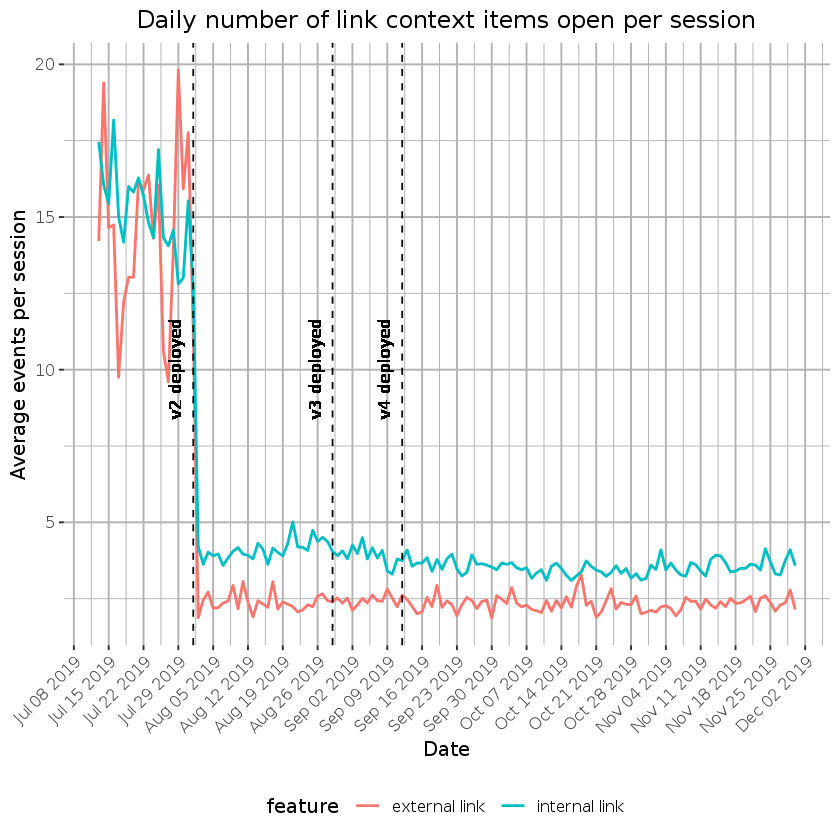

In [544]:
# Plot timeseries of average link_workflow_starts

p <- ggplot(link_context_shown_avg, aes(x= date, y = avg_events, color = feature)) +    
  geom_line(size =0.8) +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=10, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=10, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=10, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("Average events per session", labels = polloi::compress) +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "1 week") +
  labs(title = "Daily number of link context items open per session") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom')
 
p

There is a sharp decrease in the number of context shown events that occurs on the date of v2 deployment. Further investigation is needed to confirm the source of this decrease. Following that decrease, the average context items open per session remains fairly stable.

# Average number of citation workflow starts per session

## Methodology

We measured the start of a sessions with the 'window-open-from-context' action as this indicates an intent to edit in most cases. This occurs when a window was opened by clicking the edit button in a context item.

Events are recorded as follows:

Action: User clicks on the citation icon in the toolbar.
<br />
Event: citoid: window-open or window-open-from-tool
Action: User select template
Event: citoid: dialog-manual-choose or dialog-automatic-choose
Action: User makes changes and selects the check box to complete
Event: Cite: Dialog-done

Action: User clicks an an existing citation
<br />
Event: "cite-book" (or cite-web, cite-news): "context-show" then "mwcite": "window-open-from-context"
Action: User makes change and selects the check box to complete
Event: Cite: Dialog-Done

Action: User clicks on an existing reference
<br />
Event: reference: context-show then reference: windo-open-from-context
Acton: User makes changes and selects the check box to complete
Event: reference: dialog-done

We also reviews the rate of context items show to determine if the the new design made people more likely in start editing in the first place.


Notes:

Process:
Citation using template
1. Click existing citation.  feature: "cite-book" (or cite-web, cite-news), action: "context-show"
2. Click pencil. feature: "mwcite", action: "window-open-from-context"
3. Start typing url (in any of the fields). feature: "cite", action: "manual-template-input"
4. Close without saving. feature: "cite", action: "dialog-abort", 
5. Close window. feature: "cite-web", action: "context-close", 

(Citoid Events)
1. Click add citation from toolbar {feature: "citoid", action: "window-open-from-tool",
2. Switch panels: {feature: "citoid", action: "panel-switch"
3. Click template: feature = "mwcite" and action = "windown-open-from-command"
3. See VE spec for various events

Reference:
1. Click reference. {feature: "reference", action: "context-show",
2. Click edit pencil. {feature: "reference", action: "window-open-from-context"



In [547]:
#measure start from "window-open" events.
query <-
"
--find sessions that were not included in the AB test
with non_test_sessions as (
    SELECT DISTINCT event.editing_session_id as session_id
    FROM
        event_sanitized.editattemptstep
    WHERE
        event.platform = 'phone' and
        event.editor_interface = 'visualeditor' and
        event.bucket is NULL and
        year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11))
        )
SELECT
    to_date(dt) as date,
    event.feature as feature,
    event.editingsessionid as session_id,
    Count (*) as events
FROM event_sanitized.visualeditorfeatureuse as vefu
INNER JOIN
    non_test_sessions 
    ON event.editingsessionid = non_test_sessions.session_id 
WHERE
    -- started recorded full data on July 13th
     year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) and
    -- event feature in citoid, reference or mwcite
    event.feature IN ('citoid', 'reference', 'mwcite') and
    -- the first action in link workflow starts is window-open
    event.action LIKE 'window-open%'
GROUP BY
    to_date(dt),
    event.editingsessionid,
    event.feature
"

In [548]:
citation_workflow_starts <- wmf::query_hive(query)

In [549]:
citation_workflow_starts$date <- as.Date(citation_workflow_starts$date, format = "%Y-%m-%d")

In [550]:
#Find the average linkk_workflow_starts_per_session

citation_workflow_starts_avg <- citation_workflow_starts %>%
    group_by(date, feature) %>%
    summarise(total_events = sum(events),
             avg_events = mean(events))

In [551]:
head(citation_workflow_starts_avg)

date,feature,total_events,avg_events
<date>,<chr>,<int>,<dbl>
2019-07-13,reference,134,1.472527
2019-07-14,reference,171,1.744898
2019-07-15,reference,198,1.922330
2019-07-16,reference,132,1.736842
2019-07-17,reference,183,1.848485
2019-07-18,reference,109,1.703125


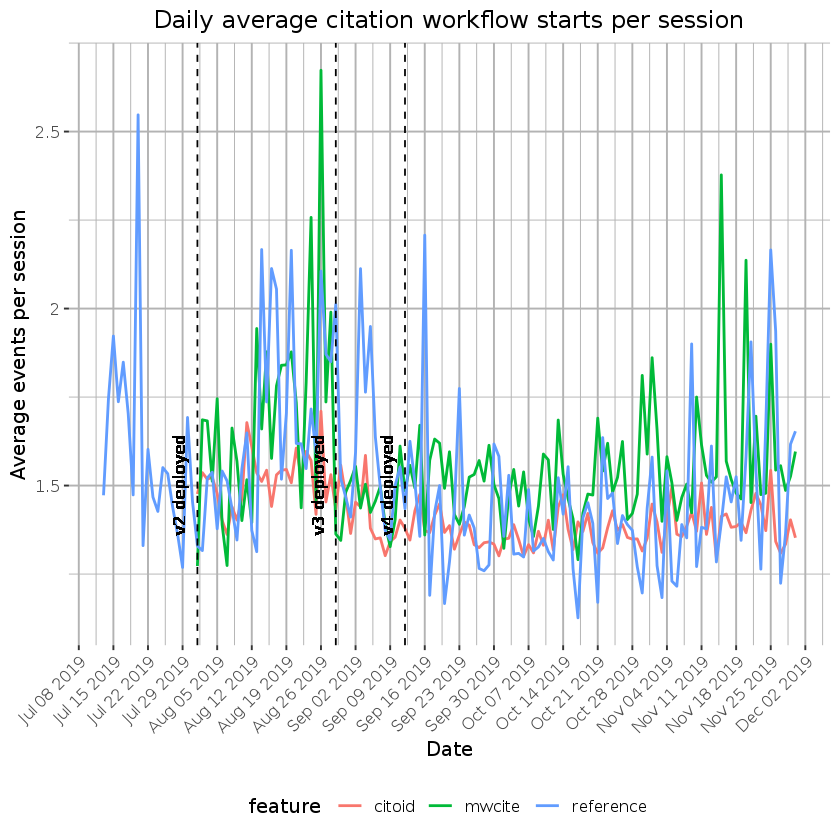

In [552]:
# Plot timeseries of average citaton_workflow_starts

p <- ggplot(citation_workflow_starts_avg, aes(x= date, y = avg_events, color = feature)) +    
  geom_line(size =0.8) +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=1.5, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=1.5, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=1.5, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("Average events per session", labels = polloi::compress) +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "1 week") +
  labs(title = "Daily average citation workflow starts per session") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom')
 
p

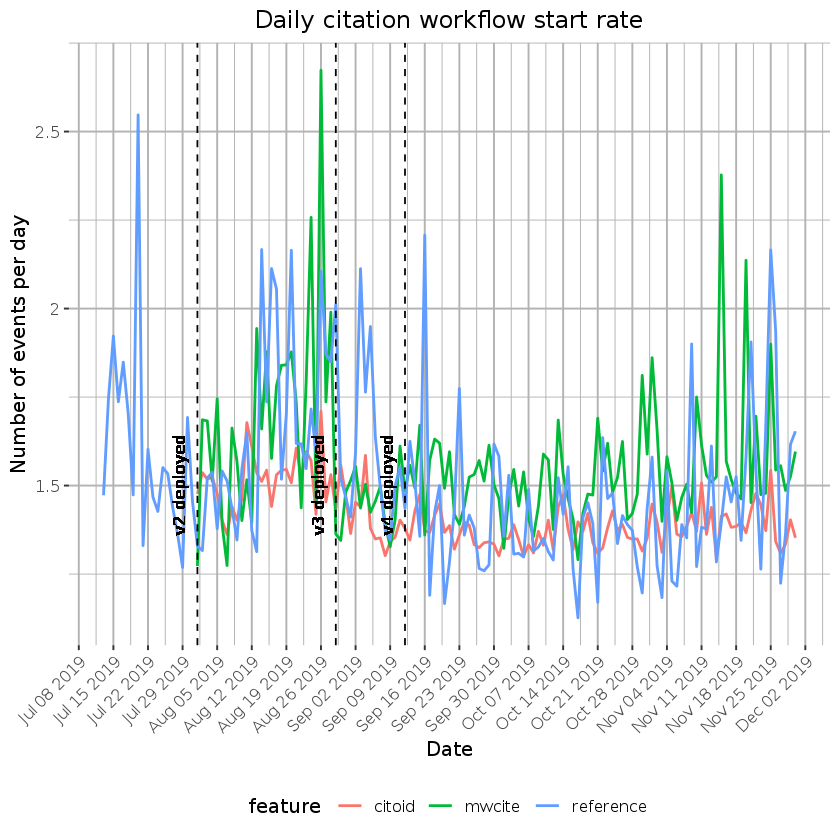

In [556]:
# Daily rate of citation worklow starts


p <- ggplot(citation_workflow_starts_avg, aes(x= date, y = avg_events, color = feature)) +    
  geom_line(size =0.8) +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=1.5, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=1.5, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=1.5, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("Number of events per day", labels = polloi::compress) +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "1 week") +
  labs(title = "Daily citation workflow start rate") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom')
 
p

In [559]:
## Review context-shown items. 
#Note: It looks like a context-show item does not appear for citoid generated references. 

query <-
"
--find sessions that were not included in the AB test
with non_test_sessions as (
    SELECT DISTINCT event.editing_session_id as session_id
    FROM
        event_sanitized.editattemptstep
    WHERE
        event.platform = 'phone' and
        event.editor_interface = 'visualeditor' and
        event.bucket is NULL and
         year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11))
        )
SELECT
    to_date(dt) as date,
    event.editingsessionid as session_id,
    SUM(If ((event.feature LIKE 'cite%' and event.action = 'context-show'),1,0)) AS citation_template_generated, 
    SUM(If ((event.feature = 'reference' and event.action = 'context-show'),1,0)) AS reference_dialog_generated
FROM event_sanitized.visualeditorfeatureuse as vefu
INNER JOIN
    non_test_sessions 
    ON event.editingsessionid = non_test_sessions.session_id 
WHERE
     year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) and
    (event.feature = 'reference' OR
    event.feature LIKE 'cite%') and
    event.action = 'context-show'
GROUP BY
    to_date(dt),
    event.editingsessionid
"

In [560]:
citation_context_shown <- wmf::query_hive(query)


In [561]:
citation_context_shown$date <- as.Date(citation_context_shown$date, format = "%Y-%m-%d")

In [564]:
head(citation_context_shown, 10)

date,session_id,citation_template_generated,reference_dialog_generated
<date>,<chr>,<int>,<int>
2019-07-13,0051d5c3a6530a85ed3c,0,1
2019-07-13,005ae326dae84c0884d0,0,2
2019-07-13,00deafa1a573e92bab42,2,0
2019-07-13,00f477b498b4959c729e,0,3
2019-07-13,02001a71ac1acd7c1dac,3,0
2019-07-13,0234ce8552ab9b307509,4,1
2019-07-13,0281998aa48b96f552f4,0,22
2019-07-13,031dc68356035eca0bf6,0,6
2019-07-13,043fa1d9468f8bfbb004,1,0


In [565]:
citation_context_shown_avg <- citation_context_shown %>%
    gather(citation_type, events, 3:4) %>%
    group_by(date, citation_type)%>%
    summarise(total_events = sum(events),
             avg_events = mean(events))

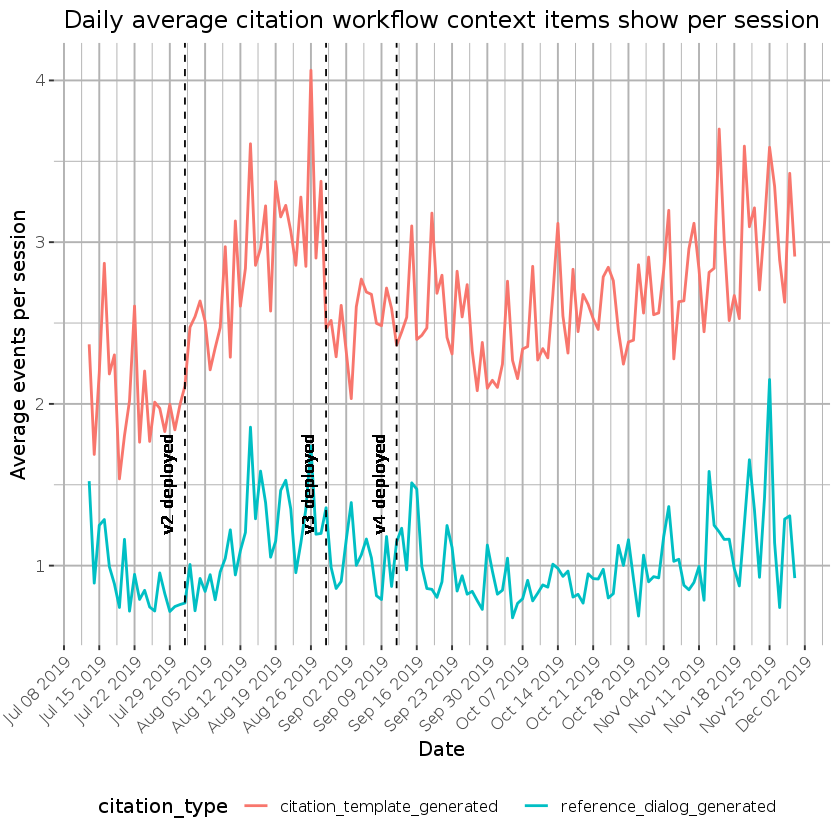

In [566]:
# Plot timeseries of average citaton_workflow_starts

p <- ggplot(citation_context_shown_avg, aes(x= date, y = avg_events, color = citation_type)) +    
  geom_line(size =0.8) +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=1.5, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=1.5, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=1.5, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("Average events per session", labels = polloi::compress) +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "1 week") +
  labs(title = "Daily average citation workflow context items show per session") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom')
 
p

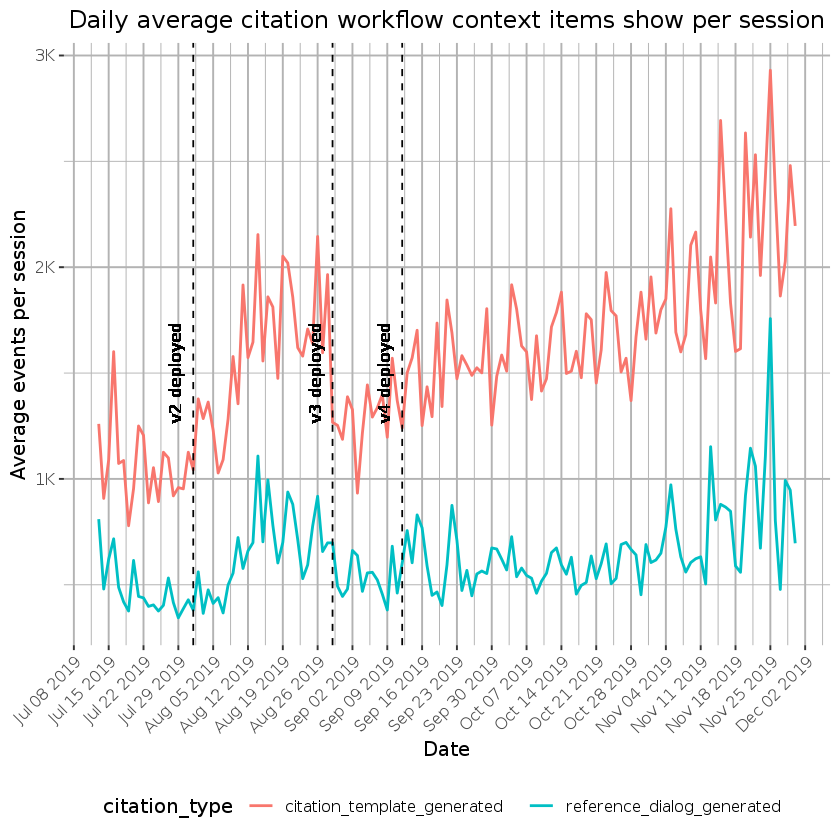

In [568]:
# Plot timeseries of daily citation workdlow starts

p <- ggplot(citation_context_shown_avg, aes(x= date, y = total_events, color = citation_type)) +    
  geom_line(size =0.8) +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=1.5e3, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=1.5e3, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=1.5e3, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("Average events per session", labels = polloi::compress) +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "1 week") +
  labs(title = "Daily average citation workflow context items show per session") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom')
 
p

# Link Workflow Completion Rate

## Methodology

We defined link completion rate as the number of sessions with link workflow starts (measured by window-open actions) that reach dialog-done, dialog-insert, or dialog-remove.

Should I try linking to save success edits as well? A person might be able to make other changes so I excluded these

In [576]:
query <-
"
--find sessions that were not included in the VE as default AB test
with non_test_sessions as (
    SELECT DISTINCT event.editing_session_id as session_id
    FROM
        event_sanitized.editattemptstep
    WHERE
        event.bucket is NULL and
        event.platform = 'phone' and
        event.editor_interface = 'visualeditor' and
        year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) 
        )
SELECT
    to_date(min(dt)) as date,
    event.editingsessionid as session_id,
    sum(cast(event.action IN ('dialog-done','dialog-insert', 'dialog-remove') as int)) >= 1 as completed
FROM event_sanitized.visualeditorfeatureuse as vefu
INNER JOIN
    non_test_sessions 
    ON event.editingsessionid = non_test_sessions.session_id 
WHERE

    year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) and
    event.feature = 'link' and
    (event.action LIKE 'window-open%' OR 
    event.action IN ('dialog-done', 'dialog-insert', 'dialog-remove'))
GROUP BY
    event.editingsessionid"

In [577]:
link_workflow_completes <- wmf::query_hive(query)

In [572]:
head(link_workflow_completes)

date,session_id,completed
<chr>,<chr>,<chr>
2019-11-25,000041a7928c92c45942,false
2019-07-22,000081e20cc4cdffd31f,true
2019-11-24,0000c5bd787ee2334648,false
2019-10-26,0000cbf71b6a6379e812,false
2019-11-16,0000cd75c2186e457cc8,false
2019-07-21,0000e4fccb9827a400f9,true


In [573]:
link_workflow_completion_rate <- link_workflow_completes  %>%
    group_by(date) %>%
    summarise(session_count = n(),
             completed = sum(completed == 'true')) %>%
    mutate(completion_rate = completed/session_count)
              
head(link_workflow_completion_rate)

date,session_count,completed,completion_rate
<chr>,<int>,<int>,<dbl>
2019-07-13,1482,973,0.6565452
2019-07-14,1720,1135,0.6598837
2019-07-15,1534,1046,0.6818774
2019-07-16,1513,978,0.6463979
2019-07-17,1437,904,0.6290884
2019-07-18,1464,989,0.6755464


In [574]:
link_workflow_completion_rate$date <- as.Date(link_workflow_completion_rate$date, format = "%Y-%m-%d")

## Link Workflow Completion Rate Overall ##

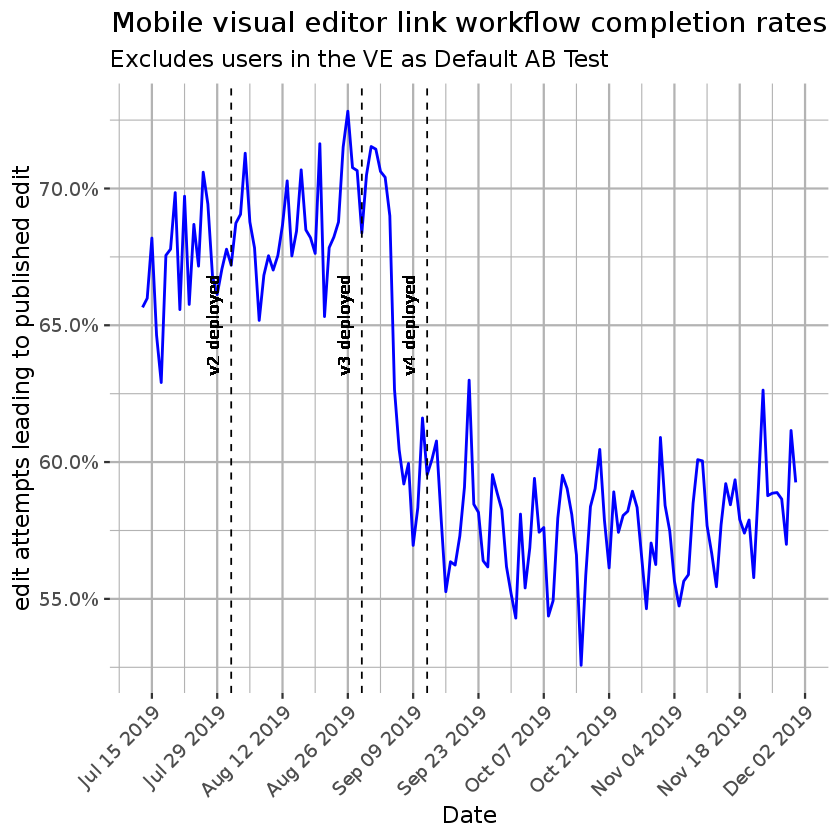

In [575]:
p <- link_workflow_completion_rate %>%
  # mutate(rolling_average = rollmean(as.numeric(edit_attempts), 7, na.pad=TRUE, align="right")) %>%
  ggplot(aes(x= date, y = completion_rate)) +    
  geom_line(size = 0.8, color = 'blue') +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=.65, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=.65, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=.65, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("edit attempts leading to published edit", labels = scales::percent) +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "2 weeks") +
  labs(title = "Mobile visual editor link workflow completion rates",
      subtitle = "Excludes users in the VE as Default AB Test") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    scale_color_brewer(palette = 'Dark2') +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom',
        legend.title  = element_text(size=12, face = 'bold'),
        legend.text = element_text(size=12))
p

# Citation Workflow Completion Rates

## Methodology

We defined citation completion rate as the number of sessions with citation workflow starts (measured by window-open action) that reach dialog-done, dialog-insert, or dialog-remove.

In [578]:
query <-
"
--find mobile VE sessions that were not included in the VE as default AB test
with non_test_sessions as (
    SELECT DISTINCT event.editing_session_id as session_id
    FROM
        event_sanitized.editattemptstep
    WHERE
        event.bucket is NULL and
        event.platform = 'phone' and
        event.editor_interface = 'visualeditor' and
        year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) 
        )
SELECT
    to_date(min(dt)) as date,
    event.editingsessionid as session_id,
    sum(cast(event.action IN ('dialog-done','dialog-insert', 'dialog-remove') as int)) >= 1 as completed
FROM event_sanitized.visualeditorfeatureuse as vefu
INNER JOIN
    non_test_sessions 
    ON event.editingsessionid = non_test_sessions.session_id 
WHERE

    year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) and
--all dialog-done events appear to be recored under either reference and cite features
    event.feature IN ('reference', 'cite') and
    (event.action LIKE 'window-open%' OR 
    event.action IN ('dialog-done', 'dialog-insert', 'dialog-remove'))
GROUP BY
    event.editingsessionid"

In [579]:
citation_workflow_completes <- wmf::query_hive(query)

In [580]:
citation_workflow_completes$date <- as.Date(citation_workflow_completes$date, format = "%Y-%m-%d")
head(citation_workflow_completes)

date,session_id,completed
<date>,<chr>,<chr>
2019-11-01,000055d97c0c18babd42,true
2019-07-21,0000e4fccb9827a400f9,false
2019-10-03,0003d81e899b731e7c19,false
2019-09-25,0005611f722789f4278c,true
2019-09-29,00065e82af3f5ff4989b,false
2019-10-25,0007fd0af01ff075e839,false


In [584]:
citation_workflow_completion_rate <- citation_workflow_completes  %>%
    group_by(date) %>%
    summarise(session_count = n(),
             completed = sum(completed == 'true')) %>%
    mutate(completion_rate = completed/session_count)
              
tail(citation_workflow_completion_rate)

date,session_count,completed,completion_rate
<date>,<int>,<int>,<dbl>
2019-11-25,289,219,0.7577855
2019-11-26,240,176,0.7333333
2019-11-27,226,161,0.7123894
2019-11-28,275,204,0.7418182
2019-11-29,217,171,0.7880184
2019-11-30,246,196,0.7967480


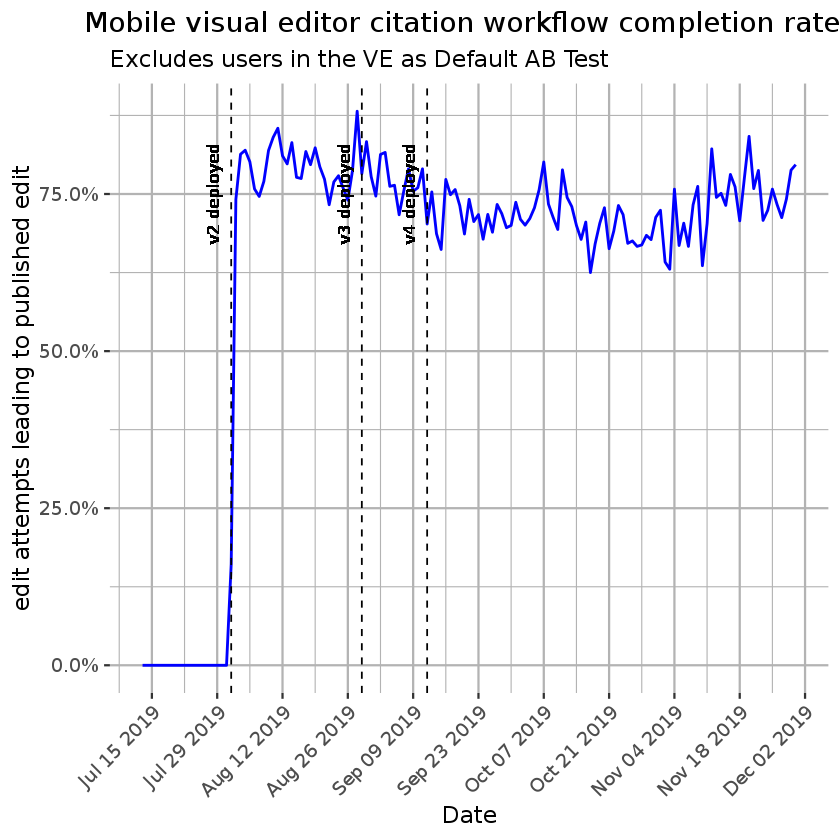

In [583]:
p <- citation_workflow_completion_rate %>%
  ggplot(aes(x= date, y = completion_rate)) +    
  geom_line(size = 0.8, color = 'blue') +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=.75, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=.75, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=.75, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("edit attempts leading to published edit", labels = scales::percent) +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "2 weeks") +
  labs(title = "Mobile visual editor citation workflow completion rates",
      subtitle = "Excludes users in the VE as Default AB Test") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    scale_color_brewer(palette = 'Dark2') +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom',
        legend.title  = element_text(size=12, face = 'bold'),
        legend.text = element_text(size=12))
p

# Edit Completion Rate

## Methodology

Data comes from the [EditAttemptStep](https://meta.wikimedia.org/wiki/Schema:EditAttemptStep) schema. We reviewed the edit completion rate for all Wikipedias on mobile Visual Editor and compared pre and post deployment rates. 

Edit completion rate is defined as the proportion of ready events that are saved. I also reviewed edit completion rate at the propotion of inits that are saved to determine the potential impacts of load time on edit completion rates.  

## Collect Data

In [282]:
query <- 
"with attempts as (
    select
        to_date(min(dt)) as date,
        sum(cast(event.action = 'saveSuccess' as int)) >= 1 as completed,
        min(event.user_id) = 0 as unregistered,
        min(event.user_editcount) between 1 and 4 as one_to_four_edits,
        min(event.user_editcount)  >= 5 AND min(event.user_editcount) < 100 as five_99_edits,
        min(event.user_editcount)  >= 100 AND min(event.user_editcount) < 1000 as onehunderd_999_edits,
        min(event.user_editcount)  >= 1000 as over_1000
    from event_sanitized.editattemptstep
    inner join canonical_data.wikis 
    on wiki = database_code and
    database_group ==  'wikipedia'
    where
        event.platform = 'phone' and
        event.editor_interface = 'visualeditor' and
        event.action in ('ready', 'saveSuccess') and
-- Remove users in the VE AB Test bucket
        event.bucket is NULL and
        year = 2019 and (month >= 06 and month <= 11) 
    group by event.editing_session_id
)
select
    date,
    sum(cast(completed as int)) / count(*) as edit_completion,
    sum(cast(completed and unregistered as int)) / sum(cast(unregistered as int)) as unregistered,
    sum(cast(completed and one_to_four_edits as int)) / sum(cast(one_to_four_edits as int)) as one_to_four_edits,
    sum(cast(completed and five_99_edits as int)) / sum(cast(five_99_edits as int)) as five_99_edits,
    sum(cast(completed and onehunderd_999_edits as int)) / sum(cast(onehunderd_999_edits as int)) as onehunderd_999_edits,
    sum(cast(completed and over_1000 as int)) / sum(cast(over_1000 as int)) as over_1000_edits
from attempts
group by date"


In [283]:
edit_completion_rate <- wmf::query_hive(query)

In [284]:
edit_completion_rate$date <- as.Date(edit_completion_rate$date, format = "%Y-%m-%d")

In [285]:
#Remove missing data due to https://phabricator.wikimedia.org/T221197#5305019

edit_completion_rate <- subset(edit_completion_rate, date < "2019-06-26" | date > "2019-07-03")

In [286]:
# rename columns
names(edit_completion_rate) <- c("date", "overall", "unregistered", "1-4 edits", "5-99 edits", "100-999 edits", "1,000+ edits")


In [293]:
tail(edit_completion_rate)

,date,overall,unregistered,1-4 edits,5-99 edits,100-999 edits,"1,000+ edits"
,<date>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
177,2019-11-25,0.3528590,0.2810507,0.36555891238670696,0.4446742502585315,0.570414201183432,0.6427566807313643
178,2019-11-26,0.3481590,0.2759753,0.35619834710743803,0.43423319931074095,0.6119565217391304,0.6218236173393124
179,2019-11-27,0.3400973,0.2649090,0.3419773095623987,0.4338942307692308,0.6243386243386243,0.6661514683153014
180,2019-11-28,0.3562919,0.2868948,0.32162921348314605,0.446875,0.5924731182795699,0.6656716417910448
181,2019-11-29,0.3587427,0.2974718,0.32732516222062,0.4443200895355344,0.5489721886336155,0.6873156342182891
182,2019-11-30,0.3528041,0.2770494,0.34045801526717556,0.4591947769314472,0.5742904841402338,0.6267361111111112


## Edit Completion Rates Overall

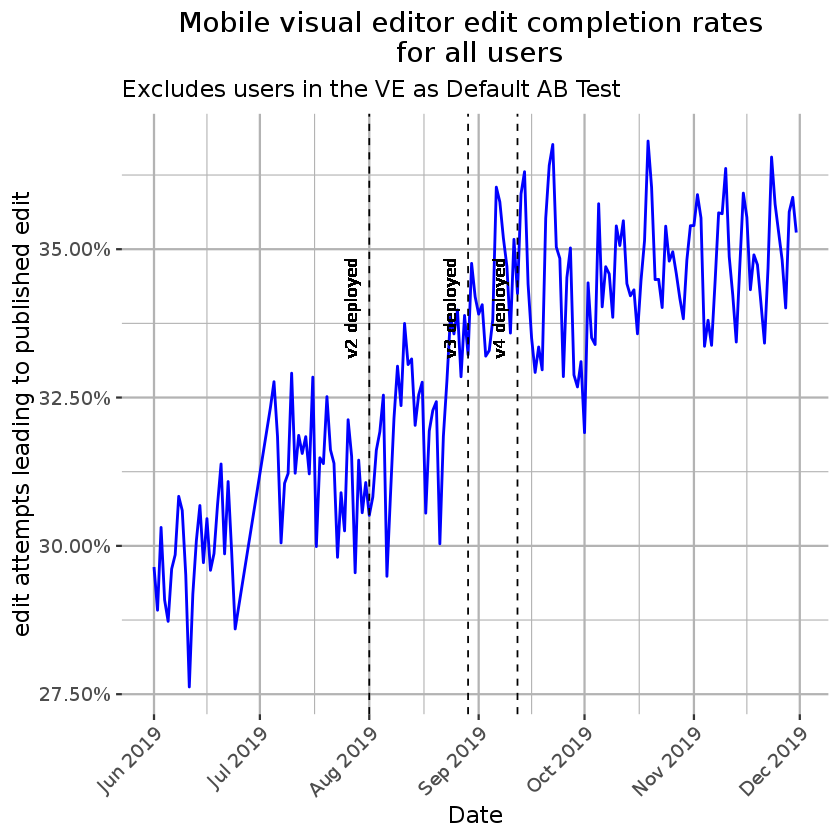

In [302]:
p <- edit_completion_rate %>%
  gather("editor_experience", "edit_attempts", 2:7)  %>%
  filter(editor_experience == 'overall') %>%
  # mutate(rolling_average = rollmean(as.numeric(edit_attempts), 7, na.pad=TRUE, align="right")) %>%
  ggplot(aes(x= date, y = as.numeric(edit_attempts))) +    
  geom_line(size = 0.8, color = 'blue') +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=.34, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=.34, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=.34, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("edit attempts leading to published edit", labels = scales::percent) +
  scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "1 month") +
  labs(title = "Mobile visual editor edit completion rates \n for all users",
      subtitle = "Excludes users in the VE as Default AB Test") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    scale_color_brewer(palette = 'Dark2') +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom',
        legend.title  = element_text(size=12, face = 'bold'),
        legend.text = element_text(size=12))
p

## Month over month changes in overall edit completion rates

In [305]:
head(edit_completion_rate)

date,overall,unregistered,1-4 edits,5-99 edits,100-999 edits,"1,000+ edits"
<date>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
2019-06-01,0.2964318,0.2343348,0.33905228758169936,0.41532976827094475,0.5636604774535809,0.59375
2019-06-02,0.2891566,0.2219778,0.32457496136012365,0.38550548112058464,0.5717948717948718,0.6403508771929824
2019-06-03,0.3031010,0.2386485,0.31983805668016196,0.44404973357015987,0.5418894830659536,0.6644736842105263
2019-06-04,0.2909049,0.2143842,0.33637873754152825,0.4012107870115575,0.5537313432835821,0.7114093959731543
2019-06-05,0.2872748,0.2248267,0.3049403747870528,0.42014925373134326,0.5408805031446541,0.672972972972973
2019-06-06,0.2961079,0.2347960,0.3324720068906115,0.41561040693795864,0.527190332326284,0.6268221574344023


In [309]:
edit_completion_monthly <- edit_completion_rate %>%
    gather("editor_experience", "edit_attempts", 2:7)  %>%
    filter(editor_experience == 'overall') %>%
    mutate(date = floor_date(date, "month")) %>%
    group_by(date) %>%
    summarise(edit_attempts = mean(as.numeric(edit_attempts))) %>%
    arrange(date) %>%
    mutate(mom_percent = (edit_attempts/lag(edit_attempts,1) -1) *100) %>%
    arrange(desc(date))

edit_completion_monthly 

date,edit_attempts,mom_percent
<date>,<dbl>,<dbl>
2019-11-01,0.3491697,0.9674821
2019-10-01,0.3458239,0.5251332
2019-09-01,0.3440173,6.1410499
2019-08-01,0.3241134,3.3255972
2019-07-01,0.3136816,5.2927314
2019-06-01,0.2979138,NA


## Edit completion rates by experience levels

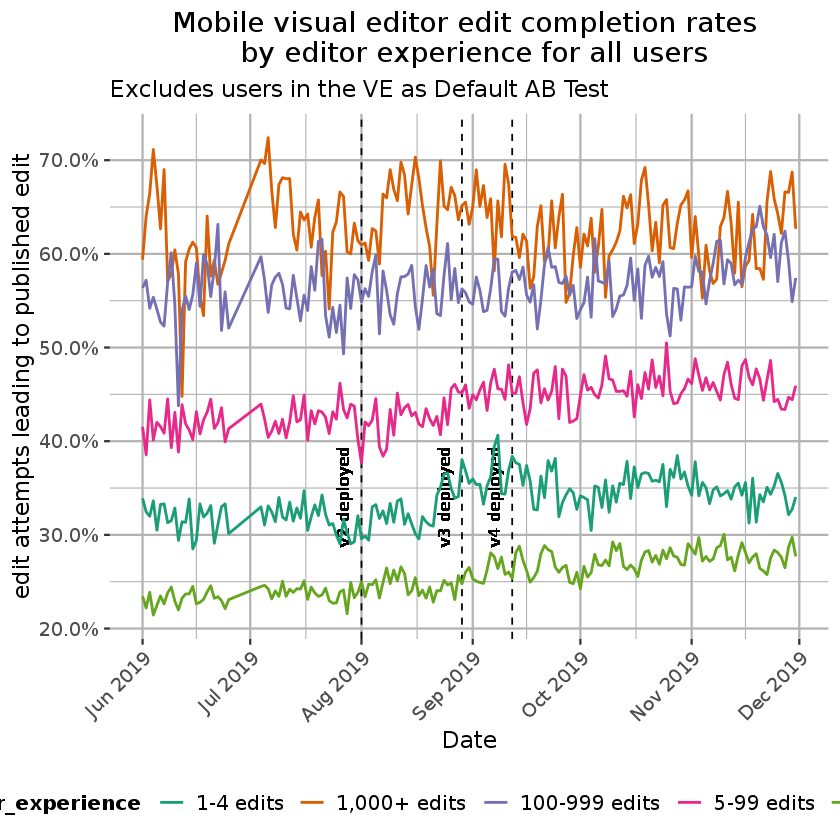

In [304]:
p <- edit_completion_rate %>%
  gather("editor_experience", "edit_attempts", 2:7)  %>%
  filter(editor_experience != 'overall') %>%
  ggplot(aes(x= date, y = as.numeric(edit_attempts), color = editor_experience)) +  
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=.34, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=.34, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=.34, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  geom_line(size = 0.8) +
  scale_y_continuous("edit attempts leading to published edit", labels = scales::percent) +
  scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "1 month") +
  labs(title = "Mobile visual editor edit completion rates \n by editor experience for all users",
      subtitle = "Excludes users in the VE as Default AB Test") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    scale_color_brewer(palette = 'Dark2') +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom',
        legend.title  = element_text(size=12, face = 'bold'),
        legend.text = element_text(size=12))
p

## Month over month changes in overall edit completion rates by experience level

In [310]:
#1-4 edits

edit_completion_monthly_1_4edits <- edit_completion_rate %>%
    gather("editor_experience", "edit_attempts", 2:7)  %>%
    filter(editor_experience == '1-4 edits') %>%
    mutate(date = floor_date(date, "month")) %>%
    group_by(date) %>%
    summarise(edit_attempts = mean(as.numeric(edit_attempts))) %>%
    arrange(date) %>%
    mutate(mom_percent = (edit_attempts/lag(edit_attempts,1) -1) *100) %>%
    arrange(desc(date))

edit_completion_monthly_1_4edits

date,edit_attempts,mom_percent
<date>,<dbl>,<dbl>
2019-11-01,0.3446814,-2.3649472
2019-10-01,0.3530303,-0.9759465
2019-09-01,0.3565097,8.5606026
2019-08-01,0.3283969,3.2742327
2019-07-01,0.3179854,-0.1175740
2019-06-01,0.3183597,NA


In [313]:
#5-99 edits

edit_completion_monthly_5_99edits <- edit_completion_rate %>%
    gather("editor_experience", "edit_attempts", 2:7)  %>%
    filter(editor_experience == '5-99 edits') %>%
    mutate(date = floor_date(date, "month")) %>%
    group_by(date) %>%
    summarise(edit_attempts = mean(as.numeric(edit_attempts))) %>%
    arrange(date) %>%
    mutate(mom_percent = (edit_attempts/lag(edit_attempts,1) -1) *100) %>%
    arrange(desc(date))

edit_completion_monthly_5_99edits

date,edit_attempts,mom_percent
<date>,<dbl>,<dbl>
2019-11-01,0.4600933,0.2448963
2019-10-01,0.4589693,1.6589214
2019-09-01,0.4514796,5.8213880
2019-08-01,0.4266430,0.3854017
2019-07-01,0.4250050,1.7894765
2019-06-01,0.4175334,NA


In [314]:
#100-999 edits

edit_completion_monthly_100_999edits <- edit_completion_rate %>%
    gather("editor_experience", "edit_attempts", 2:7)  %>%
    filter(editor_experience == '100-999 edits') %>%
    mutate(date = floor_date(date, "month")) %>%
    group_by(date) %>%
    summarise(edit_attempts = mean(as.numeric(edit_attempts))) %>%
    arrange(date) %>%
    mutate(mom_percent = (edit_attempts/lag(edit_attempts,1) -1) *100) %>%
    arrange(desc(date))

edit_completion_monthly_100_999edits

date,edit_attempts,mom_percent
<date>,<dbl>,<dbl>
2019-11-01,0.5940362,5.4061305
2019-10-01,0.5635689,-0.2291809
2019-09-01,0.5648635,0.6362142
2019-08-01,0.5612925,0.6322275
2019-07-01,0.5577661,0.6091503
2019-06-01,0.5543891,NA


In [317]:
#100-999 edits

edit_completion_monthly_over1000_edits <- edit_completion_rate %>%
    gather("editor_experience", "edit_attempts", 2:7)  %>%
    filter(editor_experience == '1,000+ edits') %>%
    mutate(date = floor_date(date, "month")) %>%
    group_by(date) %>%
    summarise(edit_attempts = mean(as.numeric(edit_attempts))) %>%
    arrange(date) %>%
    mutate(mom_percent = (edit_attempts/lag(edit_attempts,1) -1) *100) %>%
    arrange(desc(date))

edit_completion_monthly_over1000_edits

date,edit_attempts,mom_percent
<date>,<dbl>,<dbl>
2019-11-01,0.6187432,-1.5430845
2019-10-01,0.6284406,0.4806147
2019-09-01,0.6254346,-3.3260198
2019-08-01,0.6469524,0.9833006
2019-07-01,0.6406528,6.4583388
2019-06-01,0.6017874,NA


## Comparison of Edit Completion Rate starting with sessions that reach Init ##

In [480]:
query <- 
"with attempts as (
    select
        to_date(min(dt)) as date,
        sum(cast(event.action = 'saveSuccess' as int)) >= 1 as completed,
        min(event.user_id) = 0 as unregistered,
        min(event.user_editcount) between 1 and 4 as one_to_four_edits,
        min(event.user_editcount)  >= 5 AND min(event.user_editcount) < 100 as five_99_edits,
        min(event.user_editcount)  >= 100 AND min(event.user_editcount) < 1000 as onehunderd_999_edits,
        min(event.user_editcount)  >= 1000 as over_1000
    from event_sanitized.editattemptstep
    inner join canonical_data.wikis 
    on wiki = database_code and
    database_group ==  'wikipedia'
    where
        event.platform = 'phone' and
        event.editor_interface = 'visualeditor' and
        event.action in ('init', 'saveSuccess') and
-- Remove users in the VE AB Test bucket
        event.bucket is NULL and
        year = 2019 and (month >= 06 and month <= 11) 
    group by event.editing_session_id
)
select
    date,
    sum(cast(completed as int)) / count(*) as edit_completion,
    sum(cast(completed and unregistered as int)) / sum(cast(unregistered as int)) as unregistered,
    sum(cast(completed and one_to_four_edits as int)) / sum(cast(one_to_four_edits as int)) as one_to_four_edits,
    sum(cast(completed and five_99_edits as int)) / sum(cast(five_99_edits as int)) as five_99_edits,
    sum(cast(completed and onehunderd_999_edits as int)) / sum(cast(onehunderd_999_edits as int)) as onehunderd_999_edits,
    sum(cast(completed and over_1000 as int)) / sum(cast(over_1000 as int)) as over_1000_edits
from attempts
group by date"

In [481]:
edit_completion_rate_frominit <- wmf::query_hive(query)

In [482]:
edit_completion_rate_frominit$date <- as.Date(edit_completion_rate_frominit$date, format = "%Y-%m-%d")

In [483]:
#Remove missing data due to https://phabricator.wikimedia.org/T221197#5305019

edit_completion_rate_frominit  <- subset(edit_completion_rate_frominit , date < "2019-06-26" | date > "2019-07-03")

In [484]:
# rename columns
names(edit_completion_rate_frominit) <- c("date", "overall", "unregistered", "1-4 edits", "5-99 edits", "100-999 edits", "1,000+ edits")


## Edit Completion Rates from Init

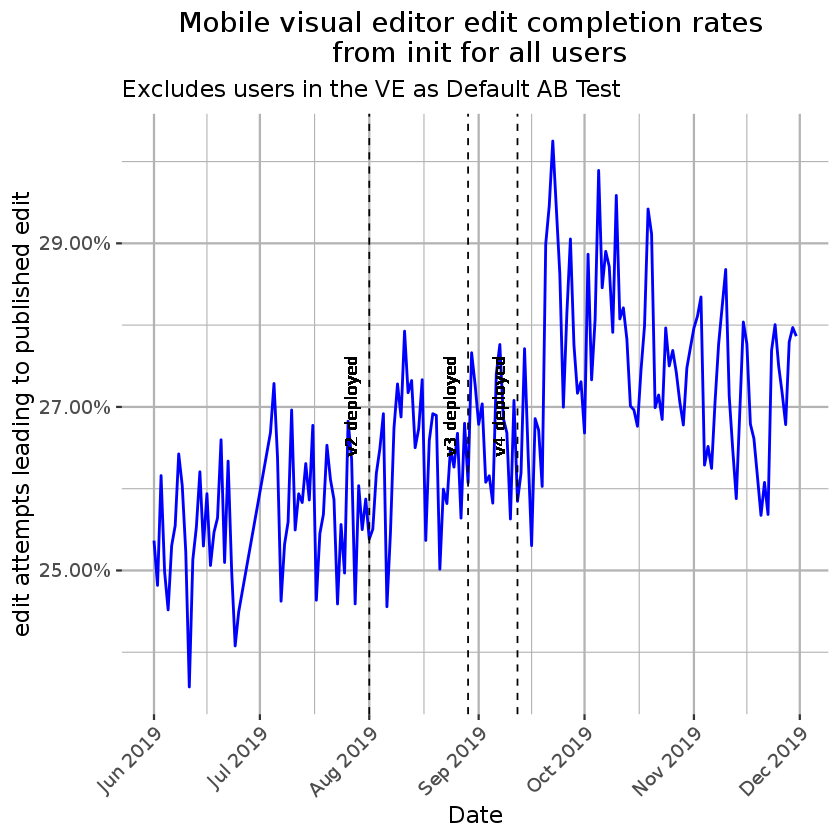

In [489]:
p <- edit_completion_rate_frominit %>%
  gather("editor_experience", "edit_attempts", 2:7)  %>%
  filter(editor_experience == 'overall') %>%
  # mutate(rolling_average = rollmean(as.numeric(edit_attempts), 7, na.pad=TRUE, align="right")) %>%
  ggplot(aes(x= date, y = as.numeric(edit_attempts))) +    
  geom_line(size = 0.8, color = 'blue') +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=.27, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=.27, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=.27, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("edit attempts leading to published edit", labels = scales::percent) +
  scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "1 month") +
  labs(title = "Mobile visual editor edit completion rates \n from init for all users",
      subtitle = "Excludes users in the VE as Default AB Test") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    scale_color_brewer(palette = 'Dark2') +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom',
        legend.title  = element_text(size=12, face = 'bold'),
        legend.text = element_text(size=12))
p

## Month over month changes in overall edit completion rates

In [487]:
edit_completion_monthly_frominit <- edit_completion_rate_frominit %>%
    gather("editor_experience", "edit_attempts", 2:7)  %>%
    filter(editor_experience == 'overall') %>%
    mutate(date = floor_date(date, "month")) %>%
    group_by(date) %>%
    summarise(edit_attempts = mean(as.numeric(edit_attempts))) %>%
    arrange(date) %>%
    mutate(mom_percent = (edit_attempts/lag(edit_attempts,1) -1) *100) %>%
    arrange(desc(date))

edit_completion_monthly_frominit 

date,edit_attempts,mom_percent
<date>,<dbl>,<dbl>
2019-11-01,0.2717410,-2.482094
2019-10-01,0.2786576,2.249882
2019-09-01,0.2725261,3.047364
2019-08-01,0.2644668,2.329141
2019-07-01,0.2584472,1.938184
2019-06-01,0.2535333,NA


In [ ]:
## Edit Completion Rates by Experience Level from Init 

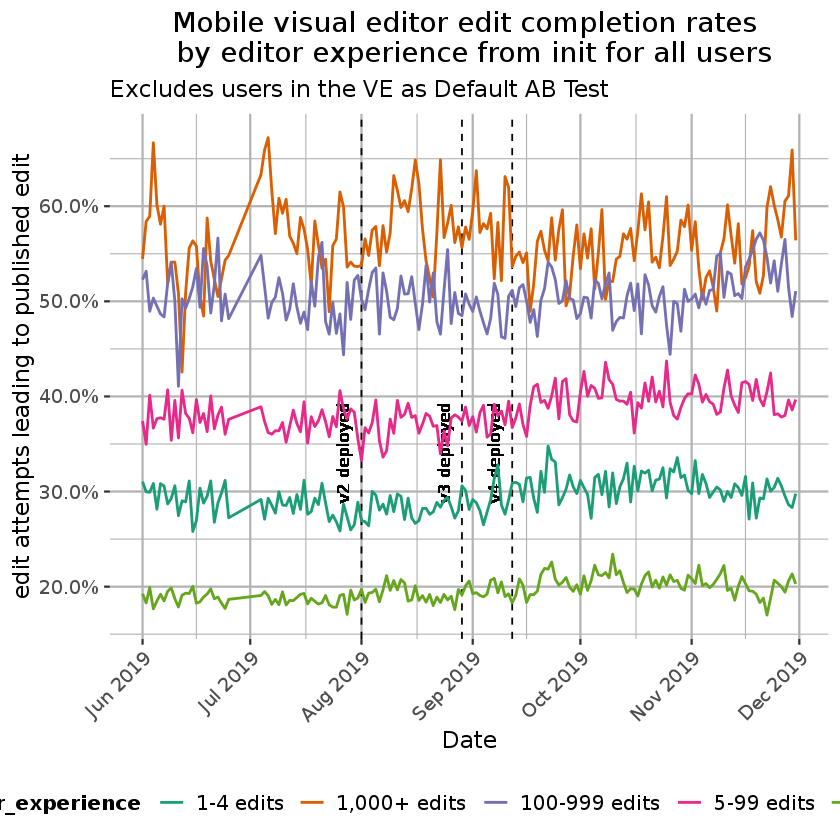

In [491]:
p <- edit_completion_rate_frominit %>%
  gather("editor_experience", "edit_attempts", 2:7)  %>%
  filter(editor_experience != 'overall') %>%
  ggplot(aes(x= date, y = as.numeric(edit_attempts), color = editor_experience)) +  
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=.34, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=.34, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=.34, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  geom_line(size = 0.8) +
  scale_y_continuous("edit attempts leading to published edit", labels = scales::percent) +
  scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "1 month") +
  labs(title = "Mobile visual editor edit completion rates \n by editor experience from init for all users",
      subtitle = "Excludes users in the VE as Default AB Test") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    scale_color_brewer(palette = 'Dark2') +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom',
        legend.title  = element_text(size=12, face = 'bold'),
        legend.text = element_text(size=12))
p